In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

import myLib_barChart as myBar
import myLib_confMatrix as myMatrix
import myLib_parseData as myParse
import myLib_pieChart as myPie
import myLib_table as myTable
import myLib_testModel as myTest
import myLib_writeFile as myWrite

# PARSE DATASET

In [2]:
vowels_data, vowels_label = myParse.loadDataFromTxt('vowels_OL')


print('\n**** OL data')
OL_data_train_vow, OL_label_train_vow, OL_data_test_vow, OL_label_test_vow = myParse.parseTrainTest(vowels_data, vowels_label, 0.7)

******* Dataset for letter ['A' 'E' 'I' 'O' 'U']

Raw shape        -> (69000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 345
1 Sample is long -> 200


**** OL data

*** Separate train-valid

Train data shape  -> (240, 600)
Train label shape -> (240,)

Test data shape   -> (103, 600)
Test label shape  -> (103,)


In [3]:
B_data, B_label = myParse.loadDataFromTxt('B_dataset')
B_train_data, B_train_label, B_test_data, B_test_label = myParse.parseTrainTest(B_data, B_label, 0.7)

******* Dataset for letter ['B']

Raw shape        -> (39400, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 197
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (136, 600)
Train label shape -> (136,)

Test data shape   -> (59, 600)
Test label shape  -> (59,)


In [4]:
M_data, M_label = myParse.loadDataFromTxt('M_dataset')
M_train_data, M_train_label, M_test_data, M_test_label = myParse.parseTrainTest(M_data, M_label, 0.7)

******* Dataset for letter ['M']

Raw shape        -> (39000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 195
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (135, 600)
Train label shape -> (135,)

Test data shape   -> (58, 600)
Test label shape  -> (58,)


In [5]:
R_data, R_label = myParse.loadDataFromTxt('R_dataset')
R_train_data, R_train_label, R_test_data, R_test_label = myParse.parseTrainTest(R_data, R_label, 0.7)

******* Dataset for letter ['R']

Raw shape        -> (39000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 195
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (135, 600)
Train label shape -> (135,)

Test data shape   -> (58, 600)
Test label shape  -> (58,)


###  Dataset of all letters

In [6]:
# Create a matrix that contains all the train data

order_data_all = OL_data_train_vow
order_data_all = np.vstack(( order_data_all, B_train_data))
order_data_all = np.vstack(( order_data_all, R_train_data))
order_data_all = np.vstack(( order_data_all, M_train_data))

order_label_all = OL_label_train_vow
order_label_all = np.hstack(( order_label_all, B_train_label))
order_label_all = np.hstack(( order_label_all, R_train_label))
order_label_all = np.hstack(( order_label_all, M_train_label))

print('order_data_all has shape   ' + str(order_data_all.shape))
print('order_label_all  has shape ' + str(order_label_all.shape))

order_data_all has shape   (646, 600)
order_label_all  has shape (646,)


In [7]:
# Shuffle the matrix of all letters
mixed_data_all = np.zeros(order_data_all.shape)
mixed_label_all = np.empty(order_label_all.shape, dtype=str) 

index_ary = list(range(0, order_data_all.shape[0]))
index_ary = random.sample(index_ary, len(index_ary)) 

for i in range(0, order_data_all.shape[0]):
    mixed_data_all[i,:] = order_data_all[index_ary[i],:]
    mixed_label_all[i]  = order_label_all[index_ary[i]]
    
print('mixed_data_all has shape   ' + str(mixed_data_all.shape))
print('mixed_label_all  has shape ' + str(mixed_label_all.shape))

mixed_data_all has shape   (646, 600)
mixed_label_all  has shape (646,)


###  Dataset of only new letters

In [8]:
# Create a matrix that contains all the train data

order_data_new = B_train_data
order_data_new = np.vstack(( order_data_new, R_train_data))
order_data_new = np.vstack(( order_data_new, M_train_data))

order_label_new = B_train_label
order_label_new = np.hstack(( order_label_new, R_train_label))
order_label_new = np.hstack(( order_label_new, M_train_label))

print('order_data_new has shape   ' + str(order_data_new.shape))
print('order_label_new  has shape ' + str(order_label_new.shape))

order_data_new has shape   (406, 600)
order_label_new  has shape (406,)


In [9]:
# Shuffle the matrix of all letters
mixed_data_new = np.zeros(order_data_new.shape)
mixed_label_new = np.empty(order_label_new.shape, dtype=str) 

index_ary = list(range(0, order_data_new.shape[0]))
index_ary = random.sample(index_ary, len(index_ary)) 

for i in range(0, order_data_new.shape[0]):
    mixed_data_new[i,:] = order_data_new[index_ary[i],:]
    mixed_label_new[i]  = order_label_new[index_ary[i]]
    
print('mixed_data_new has shape   ' + str(mixed_data_new.shape))
print('mixed_label_new  has shape ' + str(mixed_label_new.shape))

mixed_data_new has shape   (406, 600)
mixed_label_new  has shape (406,)


In [10]:
class Data_Container(object):
    def __init__(self):

        self.R_test_data       = R_test_data
        self.R_test_label      = R_test_label
        self.B_test_data       = B_test_data
        self.B_test_label      = B_test_label
        self.M_test_data       = M_test_data
        self.M_test_label      = M_test_label
        self.R_test_data       = R_test_data
        self.OL_data_test_vow  = OL_data_test_vow
        self.OL_label_test_vow = OL_label_test_vow
        
OL_testing_data = Data_Container()

#  ------------------------------------------------------------------------

# LOAD TF TRAINED MODEL

In [11]:
MODEL_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Saved_models/"

In [12]:
model = keras.models.load_model(MODEL_PATH + 'model/model.h5')

#  ------------------------------------------------------------------------

# TINY OL

### Functions

In [13]:
class Custom_Layer(object):
    def __init__(self, model):

        # Related to the layer
        self.ML_frozen = keras.models.Sequential(model.layers[:-1])
        self.ML_frozen.compile()
        self.W = np.array(model.layers[-1].get_weights()[0])
        self.b = np.array(model.layers[-1].get_weights()[1])
        self.label = ['A', 'E', 'I', 'O', 'U']
        self.l_rate = 0
        
        self.width = self.W.shape[0]
        
        
        # Related to the results fo the model
        self.confusion_matrix = []
        self.correct_ary = []
        self.mistake_ary = []
        self.totals_ary = []
        
        self.macro_avrg_precision = 0
        self.macro_avrg_recall = 0
        self.macro_avrg_F1score = 0
        
        self.title = ''
        self.filename = ''
        
        

    def predict(self, x):
        mat_prod = np.matmul(x, self.W) + self.b
        return tf.nn.softmax(mat_prod)      

In [14]:
def lettToSoft(ary, labels):
    ret_ary = np.zeros([len(ary), len(labels)])
    
    for i in range(0, len(ary)):
        for j in range(0, len(labels)):
            if(ary[i]==labels[j]):
                ret_ary[i,j] = 1

            
    return ret_ary   

In [15]:
def checkNewClass(model, y_true, y_true_soft, i, gauss):
    
    # Check if letter is new
    found = 0
    for k in range(0, len(model.label)):
        if (y_true[i] == model.label[k]):
            found = 1

    # If first time seeing this letter
    if (found == 0):

        model.label.append(y_true[i])   # Add new letter to label
        print(f'\n\n    New letter detected -> letter \033[1m{y_true[i]}\033[0m \n')
    
        if(gauss==0):
            model.W = np.hstack((model.W, np.zeros([model.width,1])))
            model.b = np.hstack((model.b, np.zeros([1])))
        elif(gauss==1):
            gaussW = np.zeros([model.width,1])
            for i in range(0,model.width):
                gaussW[i,0] = random.gauss(0, 0.01)
            gaussB = random.gauss(0, 0.01)
            model.W = np.hstack((model.W, gaussW))
            model.b = np.hstack((model.b, gaussB))
        elif(gauss==2):  # sporcariaper far funzionare LWF
            model.W = np.hstack((model.W, np.zeros([model.width,1])))
            model.b = np.hstack((model.b, np.zeros([1])))
            
                   
        print(f'    Now W is -> {model.W.shape}              and b is -> {model.b.shape}\n\n')

        y_true_soft = lettToSoft(y_true, model.label)
                
    return y_true_soft

### OL

In [16]:
def trainOneEpoch_OL(model, x, y_true):
    
    print('**********************************\nPerforming training with OL METHOD - STOCHASTICH\n')
   
    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    
    y_true_soft = lettToSoft(y_true, model.label)  # Transform the true label letters in softmax
        
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)   # Check if letter is new
        
        # PPREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])        
          
        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]

        for j in range(0,model.W.shape[0]):
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db = np.multiply(cost, learn_rate)
        model.b = model.b-db
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

In [17]:
def trainOneEpoch_OL_miniBatch(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with OL METHOD - MINI BATCH\n')
    
    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    sum_gradW = np.zeros([model.W.shape[0], 8])
    sum_gradB = np.zeros([1, 8])
    
    y_true_soft = lettToSoft(y_true, model.label)     # Transform the true label letters in softmax array
        
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)   # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        if(i%batch_size==0):
                model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,:w]
                model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]

                sum_gradW = np.zeros([h, 8])  #reset each batch  
                sum_gradB = np.zeros([1, 8])  #reset each batch   
        
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]

        for j in range(0,h): 
            # Update weights
            tmp = np.multiply(cost, y_ML[0,j]) 
            deltaW = np.zeros([1,8])
            deltaW[0,:w] = tmp  
            sum_gradW[j,:] += deltaW[0,:]

        # Update biases
        deltaB = np.zeros([1,8])
        deltaB[0,:w] = cost
        sum_gradB += deltaB

        # If last iteration
        if(i==tot_samples-1):
            model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,:w]
            model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### OL v2

In [18]:
  def trainOneEpoch_OL_v2(model, x, y_true):
    
    print('**********************************\nPerforming training with CWR METHOD - STOCASTICH \n')
    
    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    
    y_true_soft = lettToSoft(y_true, model.label)    # Transform the true label letters in softmax
            
    # Cycle over every sample
    for i in range(0, tot_samples):
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 1)    # Check if letter is new
        
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]  

        for j in range(0,model.W.shape[0]):
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,5:] = model.W[j,5:]-dW[5:]

        # Update biases
        db = np.multiply(cost, learn_rate)
        model.b[5:] = model.b[5:]-db[5:]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

In [19]:
def trainOneEpoch_OL_v2_miniBatch(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with CWR - MINI BATCH \n ')  

    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    sum_gradW = np.zeros([model.W.shape[0], 8])
    sum_gradB = np.zeros([1, 8])
    
    # Transform the true label letters in softmax array
    y_true_soft = lettToSoft(y_true, model.label)
           
    # Cycle over all input samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0) # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        # If beginning of batch
        if(i%batch_size==0):
                model.W[:,5:] = model.W[:,5:] - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,5:w]
                model.b[5:]   = model.b[5:]   - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,5:w]
                sum_gradW = np.zeros([h, 8])  # reset
                sum_gradB = np.zeros([1, 8])  # reset
            
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]

        for j in range(0,h):  
            # Update weights
            tmp = np.multiply(cost, y_ML[0,j]) 
            deltaW = np.zeros([1,8])
            deltaW[0,:tmp.shape[0]] = tmp  
            sum_gradW[j,:] += deltaW[0,:]

        # Update biases
        deltaB = np.zeros([1,8])
        deltaB[0,:cost.shape[0]] = cost
        sum_gradB += deltaB

        # If last iteration
        if(i==tot_samples-1):
            model.W[:,5:] = model.W[:,5:] - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,5:w]
            model.b[5:]   = model.b[5:]   - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,5:w]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### LWF

In [20]:
def trainOneEpochOL_LWF(model, x, y_true):
    
    print('**********************************\nPerforming training with LWF - STOCHASTIC\n ') 
    
    lam  = 0
    cntr = 1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    y_LWF = np.zeros([1, 8])    # Define container for LWF

    # DEFINE ORIGINAL WEIGHTS AND BIASES
    LWF_w = model.W
    LWF_b = model.b
    
    y_true_soft = lettToSoft(y_true, model.label)    # Transform the true label letters in softmax
         
    # Cycle over every sample
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 2)   # Check if letter is new
        
        w = model.W.shape[1]
        h = model.W.shape[0]
        
        # va da 1 a 0
        lam = 100/(100+cntr)    #1-i/493    #  1/(20+cntr)        #
             
        # PREDICTIONS
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])
        y_LWF[0,:5] = tf.nn.softmax(np.matmul(y_ML, LWF_w) + LWF_b)           
          
        
        # BACKPROPAGATION        
        cost_norm = y_pred-y_true_soft[i,:]
        cost_LWF  = y_pred-y_LWF[0,:w]

        for j in range(0,h):
            # Update weights
            deltaW_norm = np.multiply(cost_norm,1-lam)
            deltaW_LWF  = np.multiply(cost_LWF, lam)
            deltaW      = np.multiply(deltaW_norm+deltaW_LWF, y_ML[0,j])
            dW          = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db_norm = np.multiply(cost_norm, 1-lam)
        db_LWF  = np.multiply(cost_LWF, lam)
        db      = np.multiply(db_norm+db_LWF, learn_rate)
        model.b = model.b-db
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

In [21]:
def trainOneEpochOL_LWF_v2(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with LWF - MINI BATCH\n')
    
    lam  = 0
    cntr = 1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    
    y_true_soft = lettToSoft(y_true, model.label)  # Transform the true label letters in softmax array
        
    w = model.W.shape[1]
        
    LWF_w = np.zeros([model.W.shape[0], 8]) # alocate
    LWF_b = np.zeros([1, 8]) 
    y_LWF = np.zeros([1, 8])
    
    LWF_w[:,:w] = model.W   # copy from TF
    LWF_b[0,:w] = model.b
    
    # For every sample in the dataset given
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)   # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        # END OF BATCH
        if(i%batch_size==0 and i!=0):            
            LWF_w[:,:w] = np.copy(model.W)    # update the LWF w matrix
            LWF_b[0,:w] = np.copy(model.b)    # update the LWF b matrix
                
        #lam = 1/(2+cntr)
        if(cntr<batch_size):
            lam = 1
        else:
            lam = batch_size/cntr  #(cntr/493)   va da 0 a 1
    
        # PREDICTION - Frozen + OL
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])        
        y_LWF[0,:w] = tf.nn.softmax(np.matmul(y_ML, LWF_w[:,:w]) + LWF_b[0,:w])

         
        # ---- BACKPROPAGATION | MINI BATCH + LWF        
        cost_norm = y_pred-y_true_soft[i,:]
        cost_LWF  = y_pred-y_LWF[0,:w]
        
        lam_cost_norm = np.multiply(cost_norm, 1-lam)
        lam_cost_LWF  = np.multiply(cost_LWF,  lam)

        for j in range(0,h):

            # Update weights
            deltaW = np.multiply(lam_cost_norm+lam_cost_LWF, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW          
            
        # Update biases 
        db = np.multiply(lam_cost_norm+lam_cost_LWF, learn_rate)
        model.b = model.b-db   
                        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### CWR

In [22]:
def trainOneEpoch_CWR(model, x, y_true, batch_size):
        
    print('**********************************\nPerforming training CWR \n ')  

    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    TW = np.zeros([model.W.shape[0], 8])
    TB = np.zeros([1, 8])
    found_lett = np.zeros([1,8])
    
    y_true_soft = lettToSoft(y_true, model.label)    # Transform the true label letters in softmax array
           
    # Cycle over all input samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0) # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
                
        # If beginning of batch
        if(i%batch_size==0 and i!=0): 
            for k in range(0, w):
                if(found_lett[0,k]!=0):
                    tempW = np.multiply(model.W[:,k], found_lett[0,k])
                    tempB = np.multiply(model.b[k]  , found_lett[0,k])
                    model.W[:,k] = np.multiply(tempW+TW[:,k], 1/(found_lett[0,k]+1))
                    model.b[k]   = np.multiply(tempB+TB[0,k], 1/(found_lett[0,k]+1))
                    
            TW[:h,:w]  = np.copy(model.W)
            TB[0,:w]   = np.copy(model.b)
            found_lett = np.zeros([1,8])  # reset
        elif(i==0):
            TW = np.zeros([h, 8])         # reset  
            TB = np.zeros([1, 8])         # reset  
            found_lett = np.zeros([1,8])  # reset
                
        found_lett[0,np.argmax(y_true_soft[i,:])] += 1  # update the letter counter
            
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = tf.nn.softmax(np.matmul(y_ML, TW) + TB)

        # BACKPROPAGATION
        cost = y_pred[0,:w]-y_true_soft[i,:]

        # Update weights
        for j in range(0,h):
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            TW[j,:w] = TW[j,:w] - dW

        # Update biases
        db = np.multiply(cost, learn_rate)
        TB[0,:w] = TB[0,:w]-db

        # If last iteration
        if(i==tot_samples-1):
            for k in range(5, w):
                if(found_lett[0,k]!=0):
                    tempW = np.multiply(model.W[:,k], found_lett[0,k])
                    tempB = np.multiply(model.b[k]  , found_lett[0,k])
                    model.W[:,k] = np.multiply(tempW+TW[:,k], 1/(found_lett[0,k]+1))
                    model.b[k]   = np.multiply(tempB+TB[0,k], 1/(found_lett[0,k]+1))
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1
        

# Trainings

In [23]:
num_epochs = 1
batch_size_new = 8

In [24]:
# DEFINE WHICH TRAINING AND PLOTS TO SHOW

KERAS      = 1
OL_vowels  = 1
OL         = 1
OL_mini    = 1
LWF        = 1
LWF_mini   = 1
OL_v2      = 1
OL_v2_mini = 1
CWR        = 1

### Define KERAS model

In [25]:
if(KERAS==1):
    Model_KERAS = Custom_Layer(model)
    Model_KERAS.title = 'KERAS'
    Model_KERAS.filename = 'KERAS'
    Model_KERAS.label = ['A','E','I','O','U','B','R','M']
    # DO NOT PERFORM TRAINING, KEEP IT AS IT IS, IT'S THE ORIGINAL MODEL

### Train with OL only on vowels

In [26]:
if(OL_vowels==1):
    Model_OL_vowels = Custom_Layer(model)
    Model_OL_vowels.title = 'VOWELS'
    Model_OL_vowels.filename = 'OL_vowels'
    Model_OL_vowels.l_rate = 0.000005
    for i in range(0, num_epochs):
        trainOneEpoch_OL(Model_OL_vowels, OL_data_train_vow, OL_label_train_vow)

**********************************
Performing training with OL METHOD - STOCHASTICH

    Currently at 100.0% of dataset

### Train with OL method

In [27]:
if(OL==1):
    Model_OL_all_mixed = Custom_Layer(model)
    Model_OL_all_mixed.title = 'OL' 
    Model_OL_all_mixed.filename = 'OL'
    Model_OL_all_mixed.l_rate = 0.000005
    for i in range(0, num_epochs):
        trainOneEpoch_OL(Model_OL_all_mixed, mixed_data_all, mixed_label_all)

**********************************
Performing training with OL METHOD - STOCHASTICH



    New letter detected -> letter M 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.46% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.39% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with OL + mini batch

In [28]:
if(OL_mini==1):
    Model_OL_mini = Custom_Layer(model)
    Model_OL_mini.title = 'OL + mini batch'
    Model_OL_mini.filename = 'OL_batches'
    Model_OL_mini.l_rate = 0.0007
    for i in range(0, num_epochs):
        trainOneEpoch_OL_miniBatch(Model_OL_mini, mixed_data_all, mixed_label_all, batch_size_new)

**********************************
Performing training with OL METHOD - MINI BATCH



    New letter detected -> letter M 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.46% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.39% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with LWF

In [29]:
if(LWF==1):
    Model_LWF_1 = Custom_Layer(model)
    Model_LWF_1.title = 'LWF'
    Model_LWF_1.filename = 'LWF'   
    Model_LWF_1.l_rate = 0.00005
    for i in range(0, num_epochs):
        trainOneEpochOL_LWF(Model_LWF_1, mixed_data_all, mixed_label_all)   

**********************************
Performing training with LWF - STOCHASTIC
 


    New letter detected -> letter M 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.46% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.39% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train LWF + mini batches

In [30]:
if(LWF_mini==1):
    Model_LWF_2 = Custom_Layer(model)
    Model_LWF_2.title = 'LWF + mini batch'
    Model_LWF_2.filename = 'LWF_batches'
    Model_LWF_2.l_rate = 0.00005
    for i in range(0, num_epochs):
        trainOneEpochOL_LWF_v2(Model_LWF_2, mixed_data_all, mixed_label_all, batch_size_new)

**********************************
Performing training with LWF - MINI BATCH



    New letter detected -> letter M 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.46% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.39% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with OL v2 

In [31]:
if(OL_v2==1):
    Model_OL_v2 = Custom_Layer(model)
    Model_OL_v2.title = 'OL v2' 
    Model_OL_v2.filename = 'OL_v2'
    Model_OL_v2.l_rate = 0.00005
    for i in range(0, num_epochs):
        trainOneEpoch_OL_v2(Model_OL_v2, mixed_data_all, mixed_label_all)

**********************************
Performing training with CWR METHOD - STOCASTICH 



    New letter detected -> letter M 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.46% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.39% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with OL v2 + mini batch

In [32]:
if(OL_v2_mini==1):
    Model_OL_v2_miniBatch = Custom_Layer(model)
    Model_OL_v2_miniBatch.title = 'OL v2 + mini batch'
    Model_OL_v2_miniBatch.filename = 'OL_v2_batches'
    Model_OL_v2_miniBatch.l_rate = 0.0007
    for i in range(0, num_epochs):
        trainOneEpoch_OL_v2_miniBatch(Model_OL_v2_miniBatch, mixed_data_all, mixed_label_all, batch_size_new)

**********************************
Performing training with CWR - MINI BATCH 
 


    New letter detected -> letter M 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.46% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.39% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with CWR

In [33]:
if(CWR==1):
    Model_CWR = Custom_Layer(model) 
    Model_CWR.title = 'CWR'
    Model_CWR.filename = 'CWR'
    Model_CWR.l_rate = 0.00005
    for i in range(0, num_epochs):
        trainOneEpoch_CWR(Model_CWR, mixed_data_all, mixed_label_all, 10)

**********************************
Performing training CWR 
 


    New letter detected -> letter M 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.46% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.39% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

# SIMULATION PLOTS

### Original model

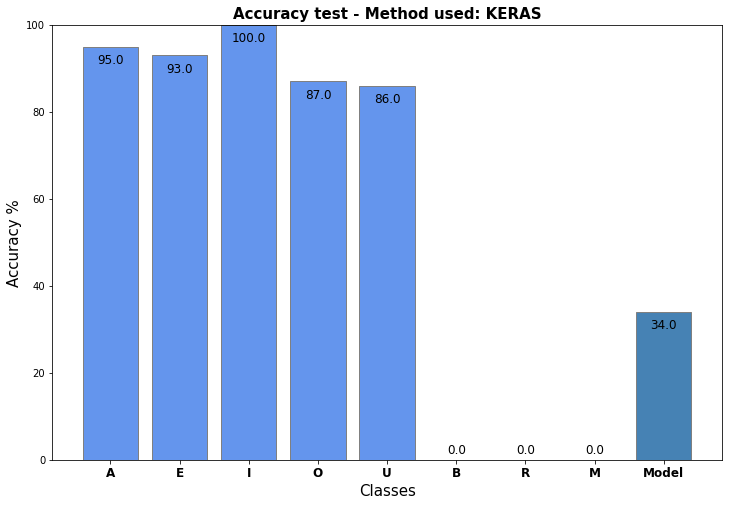

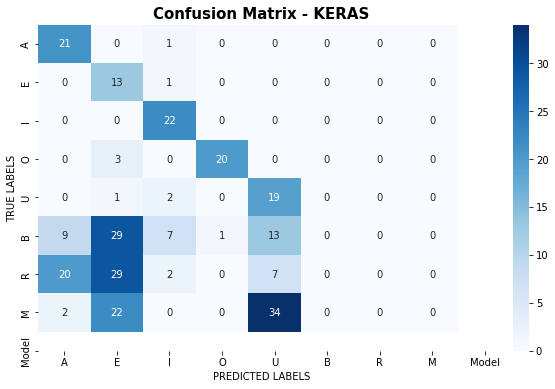

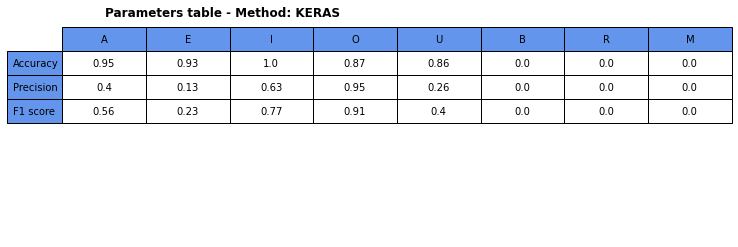

In [34]:
if(KERAS==1):
    myTest.testOL(Model_KERAS, OL_testing_data)
    myBar.plot_barChart(Model_KERAS)   
    myMatrix.plot_confMatrix(Model_KERAS)
    myTable.table_params(Model_KERAS)

### Only vowels

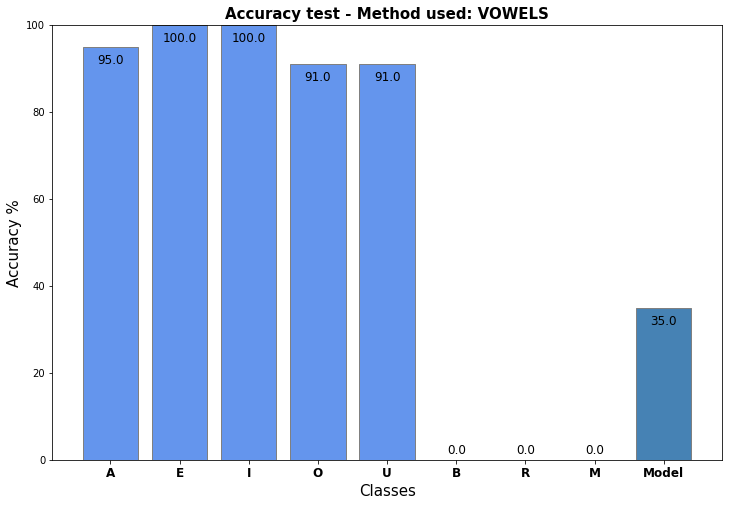

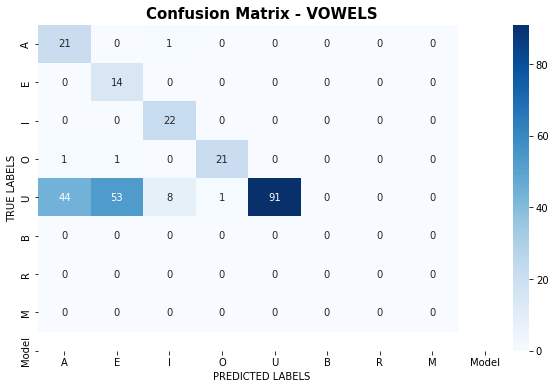

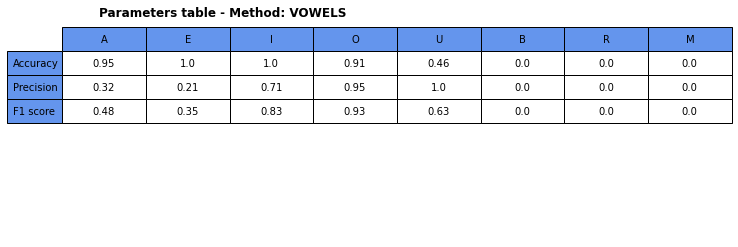

In [36]:
if(OL_vowels==1):
    myTest.testOL(Model_OL_vowels, OL_testing_data)
    myBar.plot_barChart(Model_OL_vowels)
    myMatrix.plot_confMatrix(Model_OL_vowels)
    myTable.table_params(Model_OL_vowels)

### OL

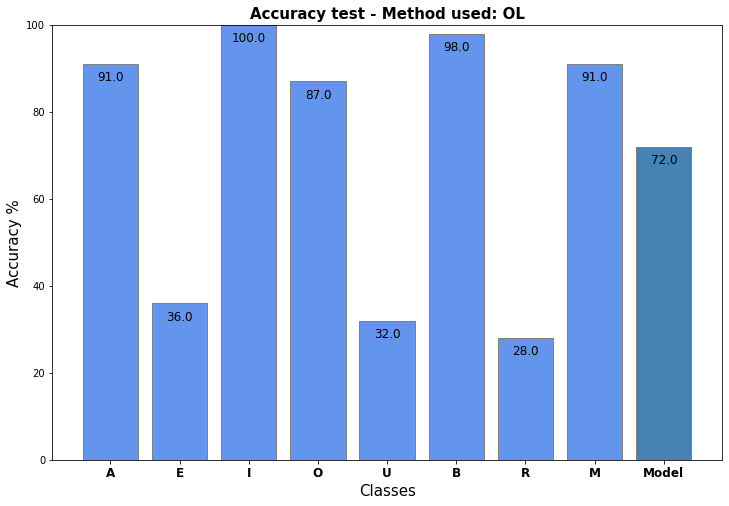

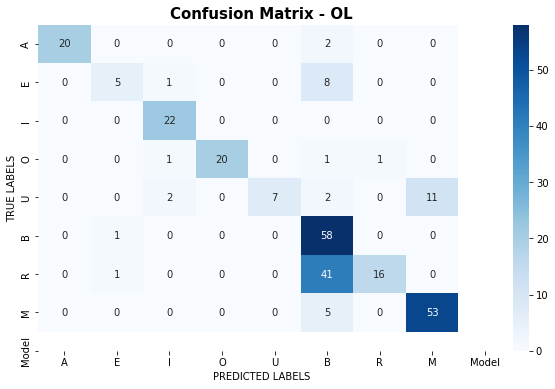

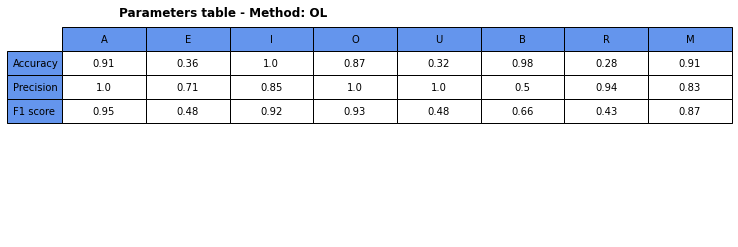

In [37]:
if(OL==1):
    myTest.testOL(Model_OL_all_mixed, OL_testing_data)
    myBar.plot_barChart(Model_OL_all_mixed)
    myMatrix.plot_confMatrix(Model_OL_all_mixed)
    myTable.table_params(Model_OL_all_mixed)

### OL + mini batch

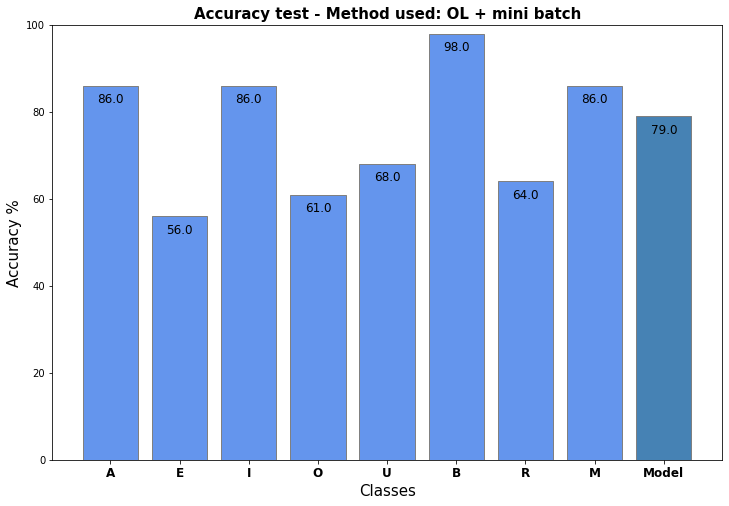

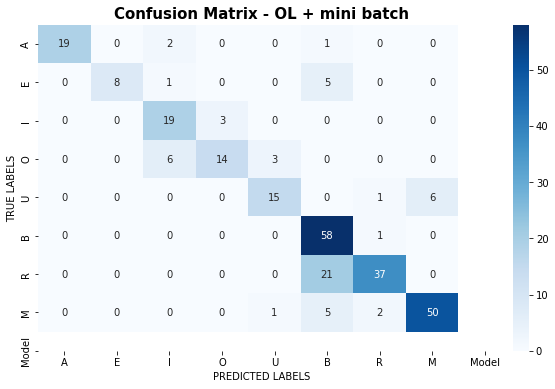

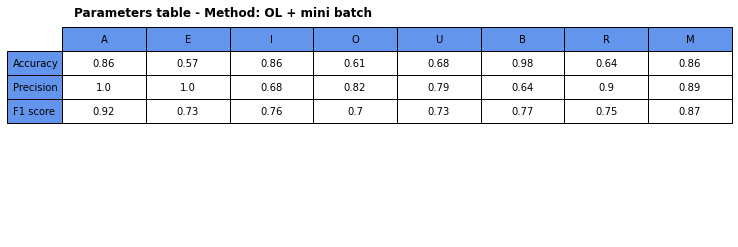

In [38]:
if(OL_mini==1):
    myTest.testOL(Model_OL_mini, OL_testing_data)
    myBar.plot_barChart(Model_OL_mini)
    myMatrix.plot_confMatrix(Model_OL_mini)
    myTable.table_params(Model_OL_mini)

### LWF

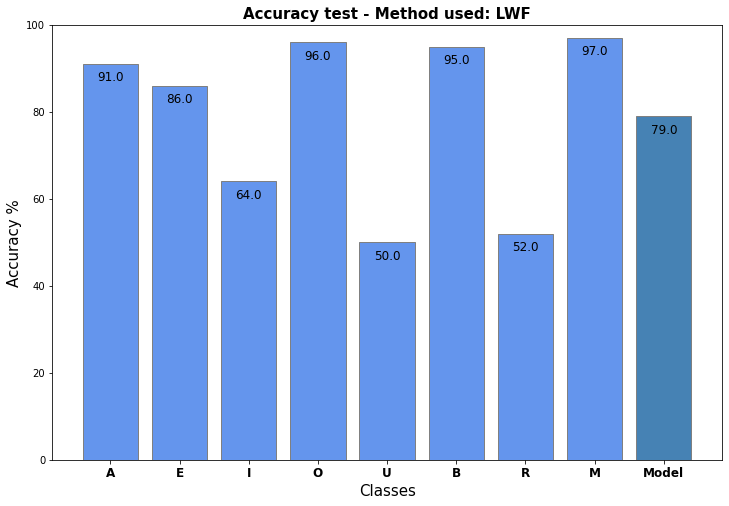

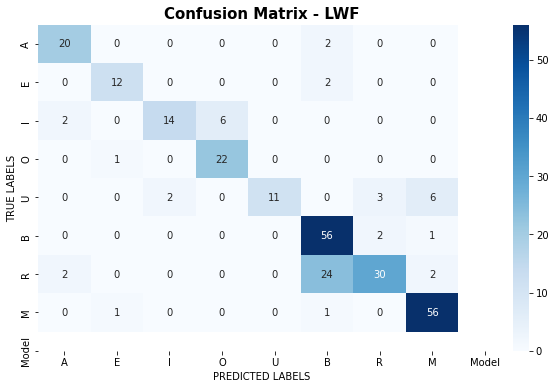

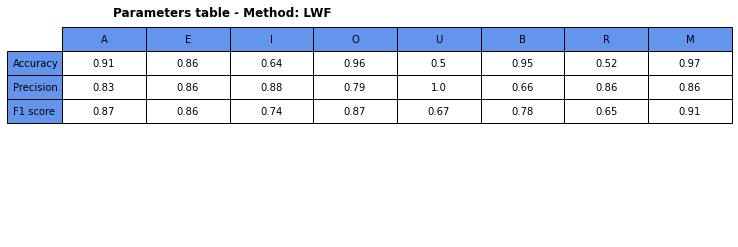

In [39]:
if(LWF==1):
    myTest.testOL(Model_LWF_1, OL_testing_data)
    myBar.plot_barChart(Model_LWF_1)
    myMatrix.plot_confMatrix(Model_LWF_1)
    myTable.table_params(Model_LWF_1)

### LWF + mini batch

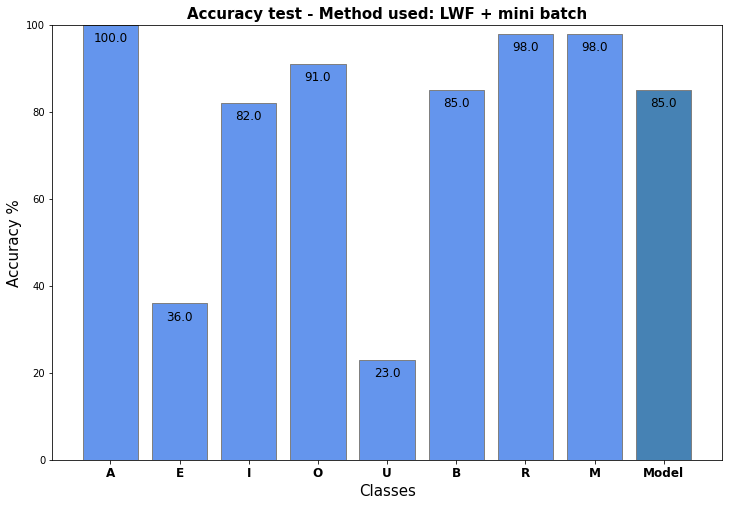

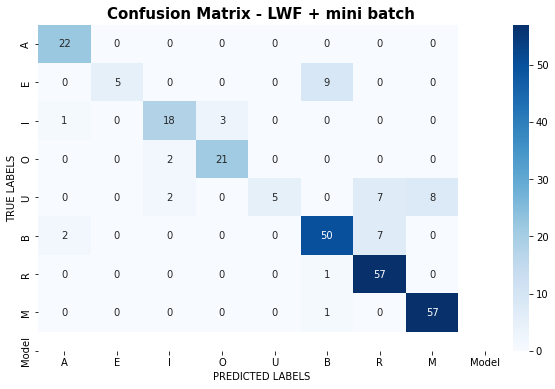

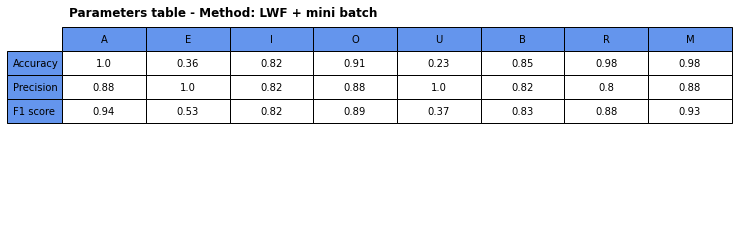

In [40]:
if(LWF_mini==1):
    myTest.testOL(Model_LWF_2, OL_testing_data)
    myBar.plot_barChart(Model_LWF_2)
    myMatrix.plot_confMatrix(Model_LWF_2)
    myTable.table_params(Model_LWF_2)

### OL v2

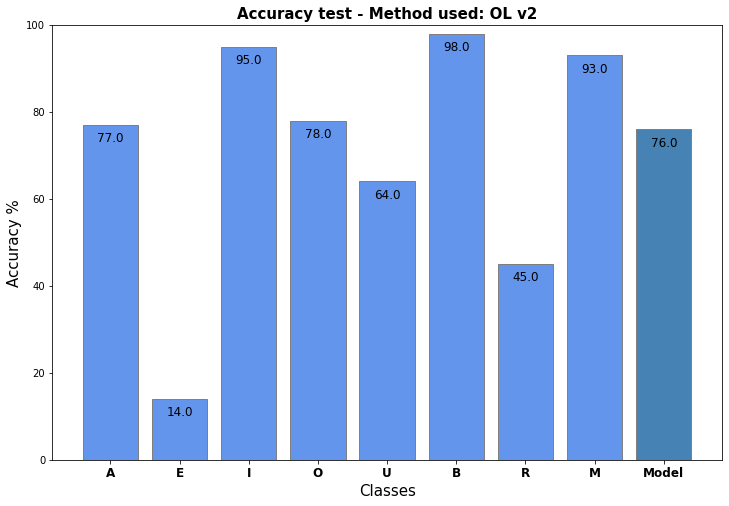

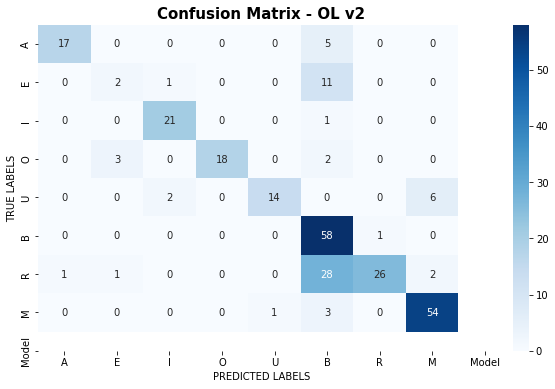

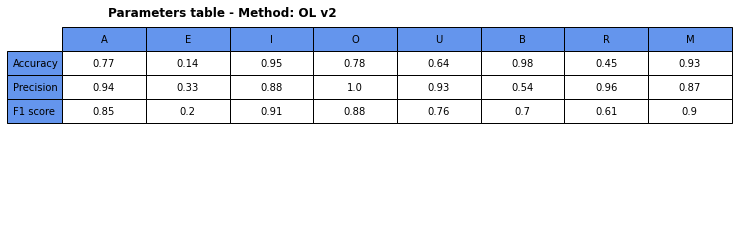

In [41]:
if(OL_v2==1):
    myTest.testOL(Model_OL_v2, OL_testing_data)
    myBar.plot_barChart(Model_OL_v2)
    myMatrix.plot_confMatrix(Model_OL_v2)
    myTable.table_params(Model_OL_v2)

### OL v2 + mini batch

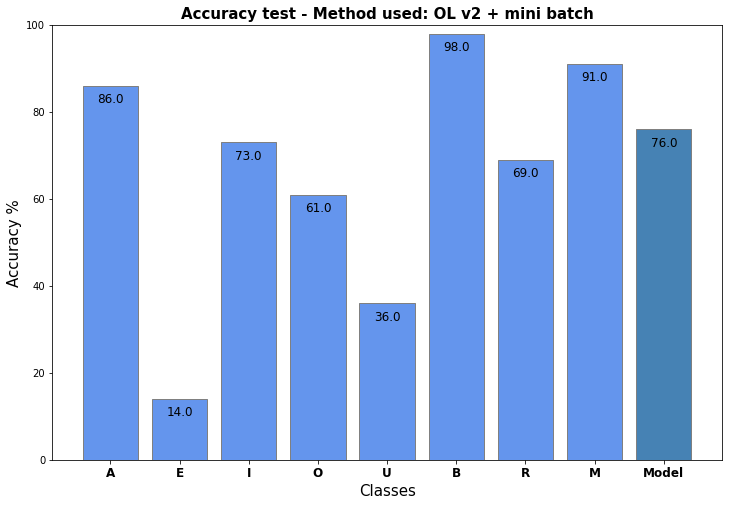

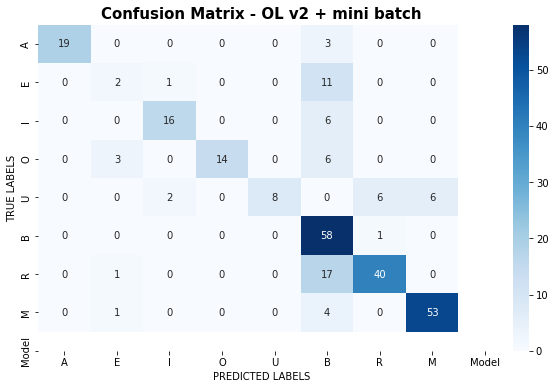

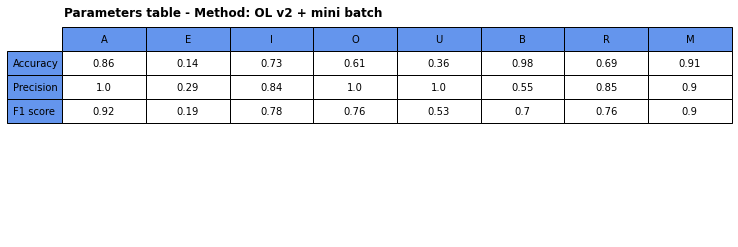

In [42]:
if(OL_v2_mini==1):
    myTest.testOL(Model_OL_v2_miniBatch, OL_testing_data)
    myBar.plot_barChart(Model_OL_v2_miniBatch)
    myMatrix.plot_confMatrix(Model_OL_v2_miniBatch)
    myTable.table_params(Model_OL_v2_miniBatch)

### CWR

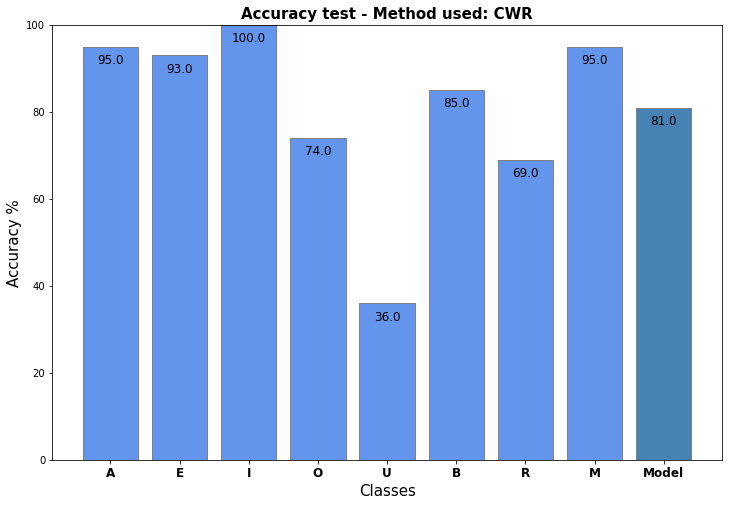

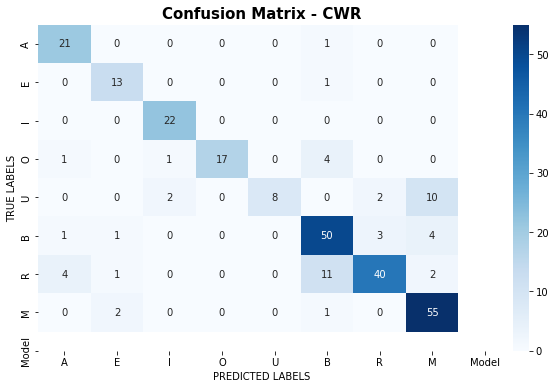

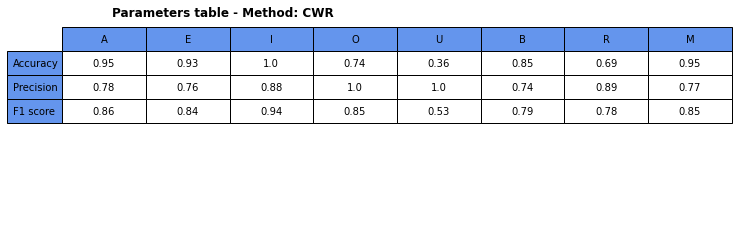

In [43]:
if(CWR==1):
    myTest.testOL(Model_CWR, OL_testing_data)
    myBar.plot_barChart(Model_CWR)
    myMatrix.plot_confMatrix(Model_CWR)
    myTable.table_params(Model_CWR)

## All plots

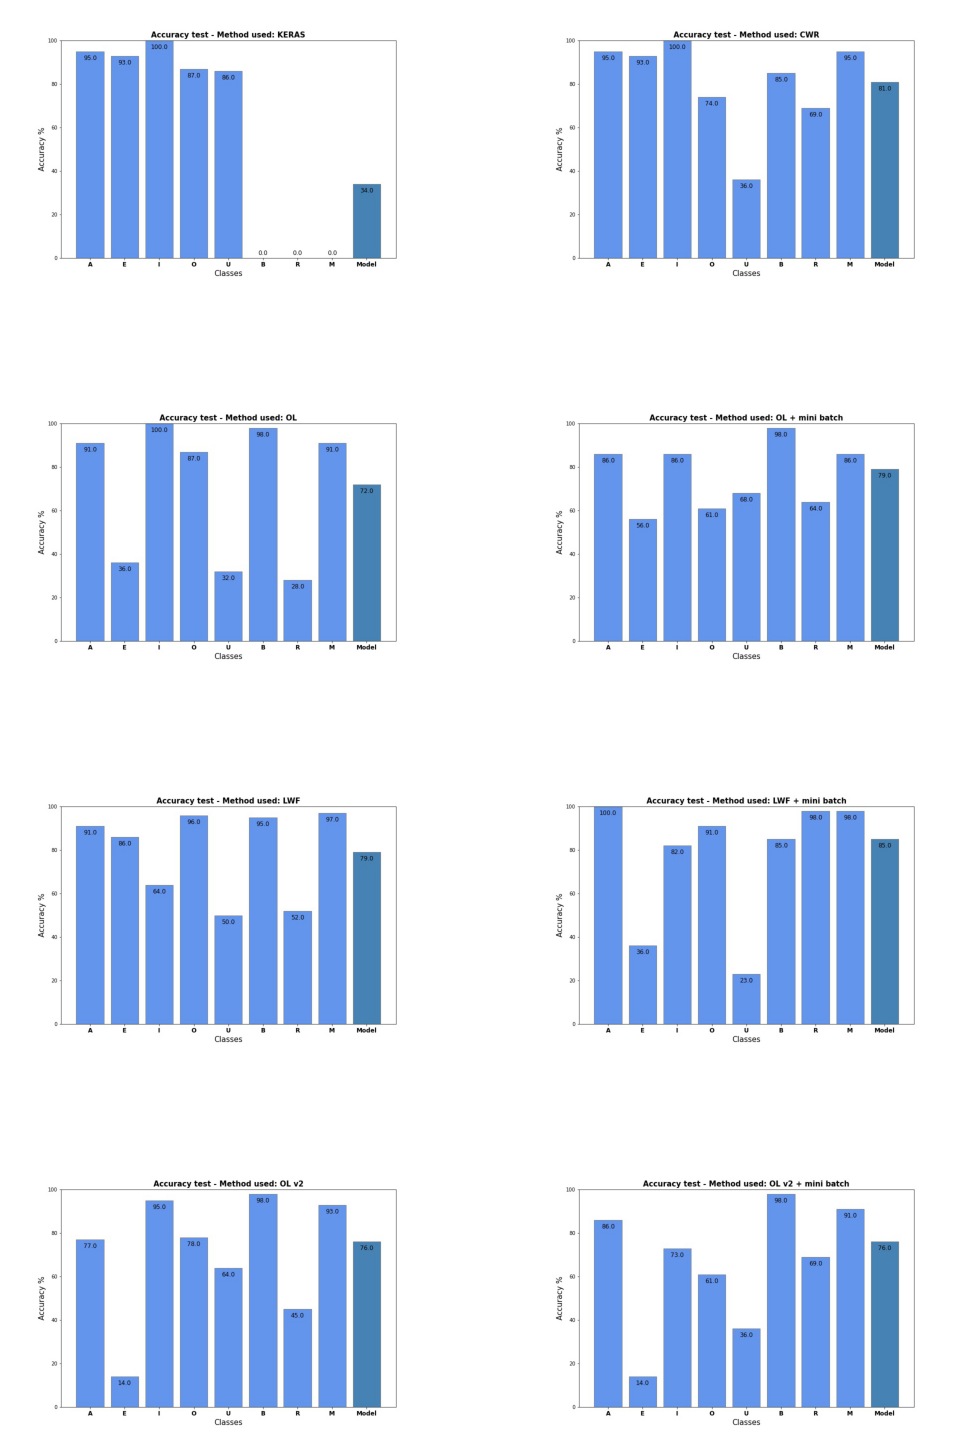

In [2]:
myBar.plot_barChart_All()

For each column the highlighted methods are the top 3 for that parameter


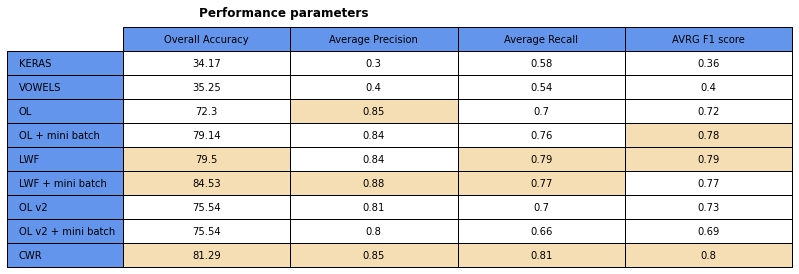

In [45]:
if(KERAS and OL_vowels and OL and OL_mini and LWF and LWF_mini and OL_v2 and OL_v2_mini and CWR):
    
    myTable.table_simulationResult(Model_KERAS, Model_OL_vowels, Model_OL_all_mixed, Model_OL_mini, 
               Model_LWF_1, Model_LWF_2, Model_OL_v2, Model_OL_v2_miniBatch, Model_CWR)  

# GENERAL PLOTS

In [46]:
# Write down in txt files all the results across 10 or so simulations          
WRITE_SIMU_RES = 1
                
if(WRITE_SIMU_RES==1):
    myWrite.save_simulationResult('Keras',     Model_KERAS)
    myWrite.save_simulationResult('OL_vowels', Model_OL_vowels)
    myWrite.save_simulationResult('OL',        Model_OL_all_mixed)
    myWrite.save_simulationResult('OL_mini',   Model_OL_mini)
    myWrite.save_simulationResult('LWF',       Model_LWF_1)
    myWrite.save_simulationResult('LWF_mini',  Model_LWF_2)
    myWrite.save_simulationResult('OL_v2',     Model_OL_v2)
    myWrite.save_simulationResult('OL_v2_min', Model_OL_v2_miniBatch)
    myWrite.save_simulationResult('CWR',       Model_CWR)

Average accuracy for Keras is: 34.71
Average accuracy for OL_vowels is: 34.89
Average accuracy for OL is: 71.4
Average accuracy for OL_mini is: 75.9
Average accuracy for LWF is: 75.0
Average accuracy for LWF_mini is: 85.97
Average accuracy for OL_v2 is: 73.2
Average accuracy for OL_v2_min is: 77.34
Average accuracy for CWR is: 80.22
******* Dataset for letter ['A' 'E' 'I' 'O' 'U']

Raw shape        -> (161000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 805
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (562, 600)
Train label shape -> (562,)

Test data shape   -> (241, 600)
Test label shape  -> (241,)


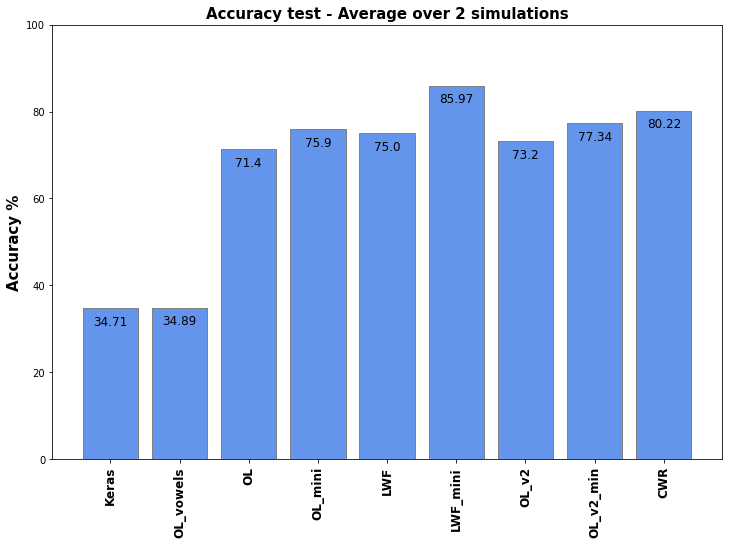

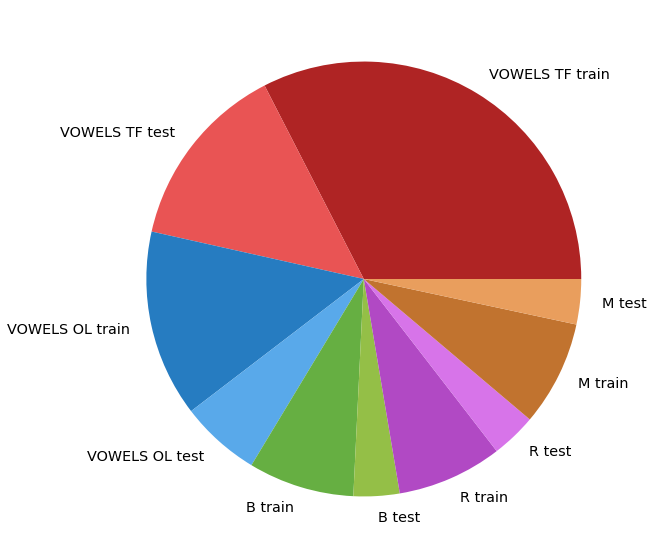

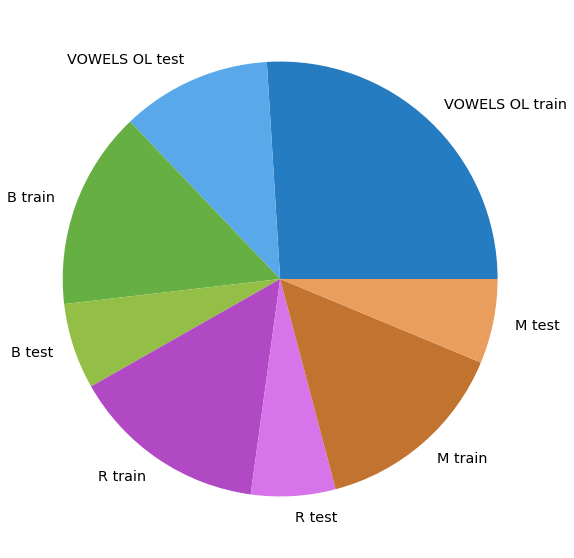

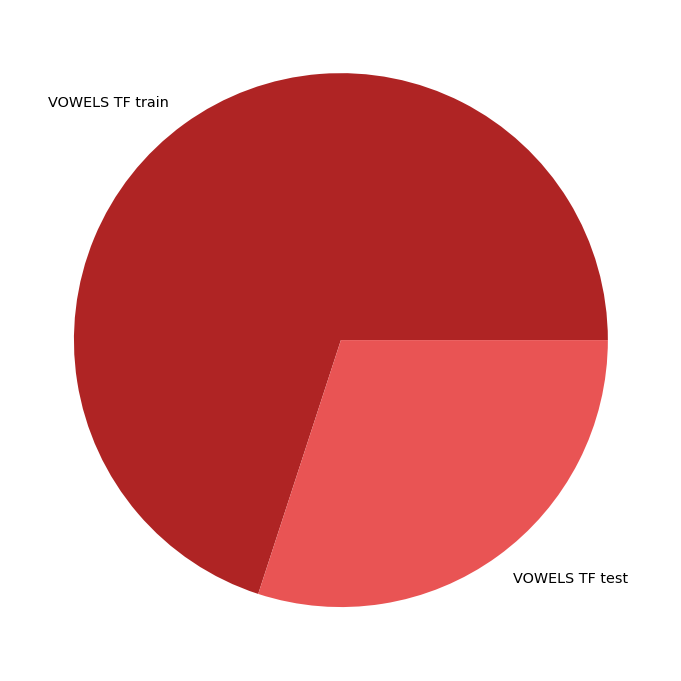

In [47]:
#myBar.plot_barChart_SimuRes(1)


ENABLE_PLOTS = 0
if(ENABLE_PLOTS==1):
    
    
    vowels_data, vowels_label = myParse.loadDataFromTxt('vowels_TF')
    TF_data_train, _, TF_data_test, _ = myParse.parseTrainTest(vowels_data, vowels_label, 0.7)


    # Plot of the pie chart of the dataset TF e OL
    dataset_shapes = np.zeros([10])
    dataset_shapes[0] = TF_data_train.shape[0]
    dataset_shapes[1] = TF_data_test.shape[0]
    dataset_shapes[2] = OL_data_train_vow.shape[0]
    dataset_shapes[3] = OL_data_test_vow.shape[0]
    dataset_shapes[4] = B_train_data.shape[0]
    dataset_shapes[5] = B_test_data.shape[0]
    dataset_shapes[6] = R_train_data.shape[0]
    dataset_shapes[7] = R_test_data.shape[0]
    dataset_shapes[8] = M_train_data.shape[0]
    dataset_shapes[9] = M_test_data.shape[0]
    myPie.plot_pieChart_datasetAll(dataset_shapes)

    
    dataset_shapes = np.zeros([8])
    dataset_shapes[0] = OL_data_train_vow.shape[0]
    dataset_shapes[1] = OL_data_test_vow.shape[0]
    dataset_shapes[2] = B_train_data.shape[0]
    dataset_shapes[3] = B_test_data.shape[0]
    dataset_shapes[4] = R_train_data.shape[0]
    dataset_shapes[5] = R_test_data.shape[0]
    dataset_shapes[6] = M_train_data.shape[0]
    dataset_shapes[7] = M_test_data.shape[0]
    # Plot of the pie chart of the dataset OL
    myPie.plot_pieChart_DatasetOL(dataset_shapes)

    # Plot of the pie chart of the dataset TF
    myPie.plot_pieChart_DatasetTF(TF_data_train.shape[0],TF_data_test.shape[0])